# Step 0: Dataset Loading and Exploration

In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import cv2
import time as time
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
import numpy as np
%matplotlib inline
import tensorflow as tf
import prettytensor as pt
from PIL import Image
import time
from datetime import timedelta
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

In [3]:
# Load pickled data
import pickle


# TODO: fill this in based on where you saved the training and testing data
training_file = 'TrafficSignData/train.p'
testing_file = 'TrafficSignData/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
labels_train = OHE_labels(y_train,43)
labels_test = OHE_labels(y_test,43)

In [4]:
def check_OHE(cls,y):
    check = np.linalg.norm(np.argmax(cls,axis=1)-y)
    if check == 0:
        print('One hot encoding correct, ok to proceed')
    else:
        print('One hot encoding doesnt match the output, check code!!!')

In [5]:
check_OHE(labels_test,y_test)
check_OHE(labels_train,y_train)

One hot encoding correct, ok to proceed
One hot encoding correct, ok to proceed


In [6]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(y_train)

# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_shape = np.shape(X_train[1])
# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Step 1: Design and Test a Model Architecture

In [7]:
def plot_random_3C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot])
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()
def plot_random_1C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot],cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()   
def plot_random_preprocess(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(pre_process_image(X[ind_plot]),cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()

    
def pre_process_image(image):

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #image = image[:,:,0]
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    image = image/255.-.5
    #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)
    
    return image

In [8]:
image = X_train[0]

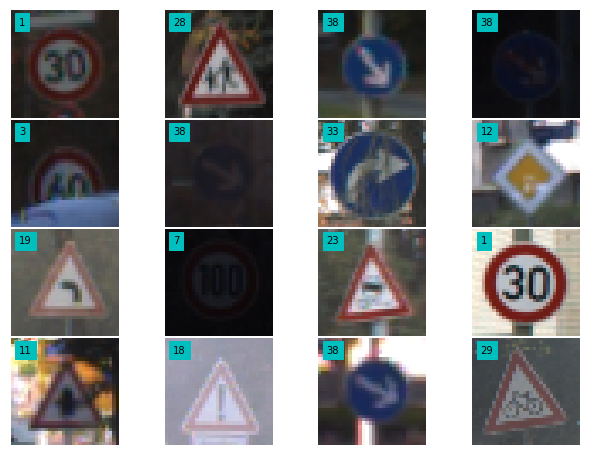

In [9]:
plot_random_3C(4,4,X_train,y_train)

In [10]:
img_resize = 32
N_classes = 43
image_shape = (img_resize,img_resize)
img_size_flat = img_resize*img_resize


image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))],
                          dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)

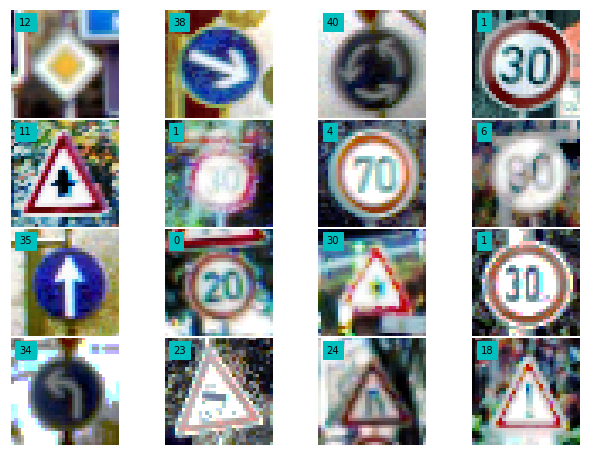

In [11]:
plot_random_3C(4,4,image_GS_train+.5,y_train)

In [12]:
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_i_sorted = sorted(data_i, key=lambda x: x[1])

In [13]:
data_pd = pd.read_csv('signnames.csv')

In [14]:
img_resize = 32
def transform_image(image,ang_range,shear_range,trans_range):

    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    
    image = pre_process_image(image)
    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #image = image[:,:,0]
    #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)
    
    return image

def get_index_dict(y_train):
    # Returns indices of each label
    # Assumes that the labels are 0 to N-1
    dict_indices = {}
    ind_all = np.arange(len(y_train))

    for i in range(len(np.unique(y_train))):
        ind_i = ind_all[y_train == i]
        dict_indices[i] = ind_i
        #print(ind_i)
    return dict_indices

def gen_transformed_data(X_train,y_train,N_classes,n_each,ang_range,shear_range,trans_range,randomize_Var):
   
   dict_indices = get_index_dict(y_train)
   n_class = len(np.unique(y_train))
   X_arr = []
   Y_arr = []
   for i in range(n_class):
       len_i = len(dict_indices[i])
       ind_rand = np.random.randint(0,len_i,n_each)
       ind_dict_class  = dict_indices[i]
       
       for i_n in range(n_each):
           img_trf = transform_image(X_train[ind_dict_class[ind_rand[i_n]]],
                                     ang_range,shear_range,trans_range)
           X_arr.append(img_trf)
           Y_arr.append(i)
           
   X_arr = np.array(X_arr,dtype = np.float32())
   Y_arr = np.array(Y_arr,dtype = np.float32())
   
   if (randomize_Var == 1):
       len_arr = np.arange(len(Y_arr))
       np.random.shuffle(len_arr)
       X_arr[len_arr] = X_arr
       Y_arr[len_arr] = Y_arr
       
   labels_arr = OHE_labels(Y_arr,43)

   return X_arr,Y_arr,labels_arr


def gen_extra_data(X_train,y_train,N_classes,n_each,ang_range,shear_range,trans_range,randomize_Var):
    
    dict_indices = get_index_dict(y_train)
    n_class = len(np.unique(y_train)) 
    X_arr = []
    Y_arr = []
    n_train = len(X_train)
    for i in range(n_train):
        #X_arr.append(transform_image(X_train[i],0,0,0)/255.)
        #Y_arr.append(y_train[i])
        for i_n in range(n_each):
            img_trf = transform_image(X_train[i],
                                      ang_range,shear_range,trans_range)
            X_arr.append(img_trf)
            Y_arr.append(y_train[i])
            
    X_arr = np.array(X_arr,dtype = np.float32())
    Y_arr = np.array(Y_arr,dtype = np.float32())
    
    if (randomize_Var == 1):
        len_arr = np.arange(len(Y_arr))
        np.random.shuffle(len_arr)
        X_arr[len_arr] = X_arr
        Y_arr[len_arr] = Y_arr
        
    labels_arr = OHE_labels(Y_arr,43)

    return X_arr,Y_arr,labels_arr

In [15]:
Image_train_GS_rot,y_train_rot,labels_train_rot = gen_transformed_data(X_train,y_train,
                                                                       43,10,30,5,5,1)

# Step 2: Design and Test a Model Architecture

In [16]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(Image_train_GS_rot_1)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = Image_train_GS_rot_1[idx, :,:,:]
    labels_batch = labels_train_rot[idx, :]

    return features_batch, labels_batch

In [17]:
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def get_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def conv_layer(input,
               num_inp_channels,
               filter_size,
               num_filters,
              use_pooling):
    shape = [filter_size, filter_size, num_inp_channels,num_filters]
    weights = get_weights(shape)
    biases = get_biases(num_filters)
    layer = tf.nn.conv2d(input = input,
                        filter = weights,
                        strides = [1,1,1,1],
                        padding = 'SAME')

    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                         ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1],
                         padding='SAME')
    layer = tf.nn.relu(layer)
    
    return layer, weights

In [18]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [19]:
def fc_layer(input,          # The previous layer.
             num_inputs,     # Num. inputs from prev. layer.
             num_outputs,    # Num. outputs.
             use_relu=True): # Use Rectified Linear Unit (ReLU)?
    weights = get_weights(shape=[num_inputs, num_outputs])
    biases = get_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer,weights

def dropout_layer(layer, keep_prob):
    layer_drop = tf.nn.dropout(layer, keep_prob)
    return layer_drop

In [20]:
img_size = 32
num_channels = 3 
Image_train_GS_rot_1 = Image_train_GS_rot
image_GS_test_1 = image_GS_test

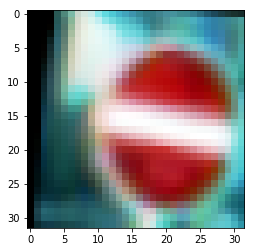

In [21]:
plt.imshow(Image_train_GS_rot_1[5]+.5)

In [22]:
features = tf.placeholder(tf.float32, shape=[None, img_size, img_size,num_channels], 
                   name='features')
labels_true = tf.placeholder(tf.float32,shape=[None,N_classes], name='y_true')

labels_true_cls = tf.argmax(labels_true, axis=1)

In [23]:
## Convlayer 0
filter_size0 = 1
num_filters0 = 3

## Convlayer 1
filter_size1 = 5
num_filters1 = 32
## Convlayer 2
filter_size2 = 5
num_filters2 = 32

## Convlayer 3
filter_size3 = 5
num_filters3 = 64
## Convlayer 4
filter_size4 = 5
num_filters4 = 64

## Convlayer 5
filter_size5 = 5
num_filters5 = 128
## Convlayer 6
filter_size6 = 5
num_filters6 = 128

## FC_size 
fc_size1 = 1024
## FC_size 
fc_size2 = 1024

## Dropout
#drop_prob = 0.5

keep_prob = tf.placeholder(tf.float32)

In [24]:
layer_conv0, weights_conv0 = \
        conv_layer(input=features,
                   num_inp_channels=num_channels,
                   filter_size=filter_size0,
                   num_filters=num_filters0,
                   use_pooling=False)

layer_conv1, weights_conv1 = \
        conv_layer(input=layer_conv0,
                   num_inp_channels=num_filters0,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=False)
layer_conv2, weights_conv2 = \
        conv_layer(input=layer_conv1,
                   num_inp_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2_drop = dropout_layer(layer_conv2, keep_prob)
    
layer_conv3, weights_conv3 = \
        conv_layer(input=layer_conv2_drop,
                   num_inp_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=False)
layer_conv4, weights_conv4= \
        conv_layer(input=layer_conv3,
                   num_inp_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)
layer_conv4_drop = dropout_layer(layer_conv4, keep_prob)

layer_conv5, weights_conv5 = \
        conv_layer(input=layer_conv4_drop,
                   num_inp_channels=num_filters4,
                   filter_size=filter_size5,
                   num_filters=num_filters5,
                   use_pooling=False)
layer_conv6, weights_conv6 = \
        conv_layer(input=layer_conv5,
                   num_inp_channels=num_filters5,
                   filter_size=filter_size6,
                   num_filters=num_filters6,
                   use_pooling=True)    
layer_conv6_drop = dropout_layer(layer_conv6, keep_prob)


layer_flat2, num_fc_layers2 = flatten_layer(layer_conv2_drop)
layer_flat4, num_fc_layers4 = flatten_layer(layer_conv4_drop)
layer_flat6, num_fc_layers6 = flatten_layer(layer_conv6_drop)

layer_flat = tf.concat([layer_flat2, layer_flat4, layer_flat6], 1)
num_fc_layers = num_fc_layers2+num_fc_layers4+num_fc_layers6

fc_layer1,weights_fc1 = fc_layer(layer_flat,          # The previous layer.
             num_fc_layers,     # Num. inputs from prev. layer.
             fc_size1,    # Num. outputs.
             use_relu=True)
fc_layer1_drop = dropout_layer(fc_layer1, keep_prob)

fc_layer2,weights_fc2 = fc_layer(fc_layer1_drop,          # The previous layer.
             fc_size1,     # Num. inputs from prev. layer.
             fc_size2,    # Num. outputs.
             use_relu=True)
fc_layer2_drop = dropout_layer(fc_layer2, keep_prob)

fc_layer3,weights_fc3 = fc_layer(fc_layer2_drop,          # The previous layer.
             fc_size2,     # Num. inputs from prev. layer.
             n_classes,    # Num. outputs.
             use_relu=False)

labels_pred = tf.nn.softmax(fc_layer3)
labels_pred_cls = tf.argmax(labels_pred, axis=1)

regularizers = (tf.nn.l2_loss(weights_conv0) 
                + tf.nn.l2_loss(weights_conv1) + tf.nn.l2_loss(weights_conv2) 
                + tf.nn.l2_loss(weights_conv3) + tf.nn.l2_loss(weights_conv4) 
                + tf.nn.l2_loss(weights_conv5) + tf.nn.l2_loss(weights_conv6) 
                + tf.nn.l2_loss(weights_fc1)  + tf.nn.l2_loss(weights_fc2) +
                tf.nn.l2_loss(weights_fc3))

In [25]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_layer3,
                                                        labels=labels_true)

In [26]:
cost = tf.reduce_mean(cross_entropy)+1e-5*regularizers

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

In [28]:
correct_prediction = tf.equal(labels_pred_cls, labels_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [29]:
batch_size = 100

In [30]:
def optimize(num_iterations):
    global total_iterations
    global best_validation_accuracy
    global last_improvement
    global best_test_accuracy
    
    global val_acc_list
    global batch_acc_list
    global test_acc_list
    
    #num_iter = np.math.floor(len(labels_train_rot)/batch_size)
    #num_iter = min(num_iter-2,num_iterations)
    num_iter = num_iterations
    for i in range(num_iter):
        total_iterations+=1
        # Get batch for training
        features_batch, labels_true_batch = random_batch()
        #idx = np.arange(batch_size*i,batch_size*(i+1))
        #features_batch = Image_GS_train_rot[idx, :,:,:]
        #labels_true_batch = labels_train_rot[idx, :]f
        feed_dict_batch = {features:features_batch,
                            labels_true: labels_true_batch,
                            keep_prob: 0.5}
        session.run(optimizer,feed_dict = feed_dict_batch)
        
        if ((total_iterations % 200 == 0) or (i == (num_iter - 1))):
            # Calculate the accuracy on the training-set.
            acc_batch = session.run(accuracy, feed_dict=feed_dict_batch)
            acc_valid = session.run(accuracy,feed_dict=feed_dict_valid)
            val_acc_list.append(acc_valid)
            batch_acc_list.append(acc_batch)
            if acc_valid > best_validation_accuracy:
                best_validation_accuracy = acc_valid
                last_improvement = total_iterations
                improved_str = '*'
                saver = tf.train.Saver()
                saver.save(sess=session, save_path='model_best_batch')
            else:
                improved_str = ''
            
            if total_iterations - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")
                break

            # Message for printing.
            if ((total_iterations % 5000 == 0) or (i == (num_iter - 1))):
                msg = "# {0:>6}, Train Acc.: {1:>6.1%}, Val Acc.: {2:>6.1%}, Test Acc.: {3:>6.1%}"
                acc_test = session.run(accuracy,feed_dict=feed_dict_test)
                
                if best_test_accuracy<acc_test:
                    saver = tf.train.Saver()
                    saver.save(sess=session, save_path='model_best_test')
                    best_test_accuracy = acc_test
                    #print_accuracy()
                # Print it.
                print(msg.format(i+1, acc_batch,acc_valid,
                                     acc_test))

In [31]:
def print_accuracy():
    acc = session.run(accuracy,feed_dict=feed_dict_test)
    print("Accuracy on test set: {0:>6.1%}".format(acc))
    
def print_confusion_matrix():
    labels_cls_pred = session.run(labels_pred_cls,feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true = y_test,y_pred = labels_cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(N_classes)
    plt.xticks(tick_marks, range(N_classes))
    plt.yticks(tick_marks, range(N_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
def plot_error_examples():
    correct,labels_cls_pred = session.run([correct_prediction,labels_pred_cls],
                                          feed_dict=feed_dict_test)
    incorrect = (correct == False)
    X_incorrect = X_test[incorrect]
    y_incorrect = y_test[incorrect]
    y_pred = labels_cls_pred[incorrect]
    
    plot_random_3C(3,3,X_incorrect,y_incorrect)

def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<13:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(image_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [32]:
feed_dict_test = {features: image_GS_test_1,
                 labels_true: labels_test,
                 labels_true_cls:y_test,
                 keep_prob:1.0}

In [33]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [34]:
# print_accuracy()

In [35]:
val_acc_list = []
batch_acc_list = []
train_acc_list = []

In [36]:
batch_size = 512

In [ ]:
start_time = time.time()
total_iterations = 0
require_improvement = 10000
ang_rot = 10
trans_rot = 2
shear_rot = 2
n_opt = 40000
best_test_accuracy = 0.0
    
for i_train in range(1):
    best_validation_accuracy = 0.0
    last_improvement = 0

    #Image_train_GS_rot,y_train_rot,labels_train_rot = gen_transformed_data(X_train,y_train,43,5000,30,5,5,1)
    
    
    if i_train>-1:
        ang_rot = 10*0.9**(i_train)
        trans_rot = 2*0.9**(i_train)
        shear_rot = 2*0.9**(i_train)
        require_improvement = 5000
        n_opt = 10000
        

        
        
    X_train_SS, X_valid_SS, y_train_SS , y_valid_SS = \
                                train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.1,
                                                 random_state=22)
    labels_valid_SS = OHE_labels(y_valid_SS,43)
    image_GS_valid = np.array([pre_process_image(X_valid_SS[i]) for i in range(len(X_valid_SS))],
                          dtype = np.float32)
    #image_GS_valid = np.reshape(image_GS_valid,(-1,32,32,1))
    
    feed_dict_valid = {features: image_GS_valid,
                 labels_true: labels_valid_SS,
                 labels_true_cls:y_valid_SS,
                 keep_prob:1.0}

    Image_train_GS_rot,y_train_rot,labels_train_rot = gen_extra_data(X_train_SS,y_train_SS,43,5,
                                                                     ang_rot,trans_rot,shear_rot,1)
    print('Optimization Loop # '+str(i_train))    
    Image_train_GS_rot_1 = Image_train_GS_rot 
    #np.reshape(Image_train_GS_rot,(-1,32,32,1))
    #
    optimize(n_opt)
    #print_accuracy()
    
    
end_time = time.time()

time_diff = end_time-start_time

Optimization Loop # 0
